In [1]:
###############################################################################
################################## Objectif
###############################################################################
# L'objectif est d'utiliser le dataset du box-office pour prédire combien il va faire au box office (variable revenue)
# Il est disponible ici : https://www.kaggle.com/c/tmdb-box-office-prediction
# La dataset contient une panoplie d'information comme le budget, les acteurs, la compagnie de production, l'année, etc...

###############################################################################
################################## Fonctions et dépendances
###############################################################################
# J'aime bien mettre l'ensemble de mes fonctions en début de code, comme ça le code est moins contaminé.

import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import re
import ast
import datetime

# Normalement, je garde les warnings, mais la pour la lisibilité je les ai enlevés
def extraire_info(x_x,col):
    x_x[col] = x_x[col].fillna("no " + col)
    lt = []
    for i in range(len(x_x[col])):
        temp = x_x[col][i]
        if temp == ("no " + col):
            None
        else:
            temp = temp[1:(len(temp)-1)]
            temp = ast.literal_eval(re.search('({.+})', temp).group(0))
            if type(temp).__name__ != 'dict':
                for j in temp:
                    lt.append(j)
            else:
                lt.append(temp)
    
    lt = list(set([i.pop('name') for i in lt]))
    df = pd.DataFrame()
    for i in lt:
        temp = []
        for j in range(len(x_x)):
            temp.append(1 if i in x_x[col][j] else 0)
        df[col + '_' + i] = temp
    return df

def extraire_freq(x_x,col):
    x_x[col] = x_x[col].fillna("no " + col)
    x_x[col] = ["no " + col if i == "[]" else i for i in x_x[col]]
    lt = []
    for i in range(len(x_x[col])):
        temp = x_x[col][i]
        if temp == ("no " + col):
            None
        else:
            temp = temp[1:(len(temp)-1)]
            temp = ast.literal_eval(re.search('({.+})', temp).group(0))
            if type(temp).__name__ != 'dict':
                for j in temp:
                    lt.append(j)
            else:
                lt.append(temp)
    
    lt = list([i.pop('name') for i in lt])
    lt = pd.DataFrame(lt)
    lt.columns = ["freq"]
    lt = lt.groupby(lt.freq).size().reset_index(name='count')
    lt = lt.sort_values(by='count',ascending=False)
    return lt

def features_corr(x,y):
    cols = ['col_name','coef','coef_abs']
    corr_mat = pd.DataFrame(columns=cols)
    
    for i in range(len(x.columns)):
        corr_mat.loc[i] = (x.columns[i]
                            ,np.corrcoef(y,x.iloc[:,i])[0][1]
                            ,abs(np.corrcoef(y,x.iloc[:,i])[0][1]))
    corr_mat = corr_mat.sort_values(by='coef_abs',ascending=False)
    return corr_mat

def extraire_info_test(df,col,x_test):
    df_test = pd.DataFrame()
    for i in df.columns:
        col_a_ajouter = i.lstrip(col + '_')
        temp = [1 if col_a_ajouter in j else 0 for j in x_test[col]]
        df_test[i] = temp
    return df_test

def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

def rmsle_grid(y_true, y_pred, **kwargs):
    return -np.sqrt(mean_squared_log_error(np.exp(y_true), np.exp(y_pred)))

def y_to_today(x,y):
    df_date = pd.to_datetime(x['release_date'])
    df_date = df_date.fillna(datetime.datetime(2000, 1, 1))
    df_year = df_date.dt.year
    nb_years = 2019 - df_year
    nb_years = (1.02**nb_years)
    return y * nb_years

def y_from_today(x,y):
    df_date = pd.to_datetime(x['release_date'])
    df_date = df_date.fillna(datetime.datetime(2000, 1, 1))
    df_year = df_date.dt.year
    nb_years = 2019 - df_year
    nb_years = (1.02**nb_years)
    return y / nb_years

def extraire_nb(x_x,col):
    x_x[col] = x_x[col].fillna("no " + col)
    lt = []
    for i in range(len(x_x[col])):
        temp = x_x[col][i]
        if temp == ("no " + col):
            lt.append(0)
        else:
            temp = temp[1:(len(temp)-1)]
            temp = ast.literal_eval(re.search('({.+})', temp).group(0))
            lt.append(len(temp))
    lt = pd.Series(lt)
    lt = lt.rename('nb_' + col)
    return lt

###############################################################################
################################## Importation des données
###############################################################################

train= pd.read_csv("C:/Users/sagau/Desktop/Kaggle/TMDB/train.csv")
test = pd.read_csv('C:/Users/sagau/Desktop/Kaggle/TMDB/test.csv')

x_x = train.iloc[:,1:22]
y_train = train.iloc[:,22]
x_test = test.iloc[:,1:22]

print('Nombre de ligne dans le dataset d''entrainement : ',len(x_x))
print('Nombre de ligne dans le dataset de test : ',len(x_test))

x_x['dataset'] = 'train'
x_test['dataset'] = 'test'
x_x = pd.concat([x_x,x_test],ignore_index=True)
idx_train = list(x_x.loc[x_x['dataset'] == 'train'].index)
idx_test = list(x_x.loc[x_x['dataset'] == 'test'].index)

del train, test # Enlever de la memoire. Un peu inutile ici, mais c'est une bonne pratique.

################################## Visualiser les 5 premières lignes
x_x.head()

Nombre de ligne dans le dataset dentrainement :  3000
Nombre de ligne dans le dataset de test :  4398


,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,dataset
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",train
1,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",train
2,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",train
3,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",train
4,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",train


In [2]:
################################## On fait la même chose pour la variable à prédire
y_train.head()

0    12314651
1    95149435
2    13092000
3    16000000
4     3923970
Name: revenue, dtype: int64

In [3]:
###############################################################################
################################## Visualisation de la variable à prédire
###############################################################################
print(y_train.hist())
print(y_train.describe())

AxesSubplot(0.125,0.11;0.775x0.77)
count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64


AxesSubplot(0.125,0.125;0.775x0.755)
count    3000.000000
mean       15.959894
std         3.071323
min         0.000000
25%        14.682516
50%        16.637310
75%        18.048445
max        21.141685
Name: revenue, dtype: float64


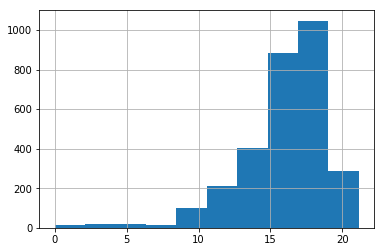

In [4]:
# Clairement, la variable n'est pas linéaire.
# Comme la variable n'est pas linéaire, un modèle qui exploite les relations linéaires ne peut pas fonctionner.
# Dès lors, on va faire une transformation pour essayer de la rendre linéaire.
# Comme on peut percevoir que la variable est exponentielle, 
# on va faire une transformation logarithmique (inverse du l'exponentiel)
# pour la transformer en variable linéaire.

y_train_log = np.log(y_train)
print(y_train_log.hist())
print(y_train_log.describe())

AxesSubplot(0.125,0.125;0.775x0.755)
count    7.398000e+03
mean     2.260146e+07
std      3.694867e+07
min      0.000000e+00
25%      0.000000e+00
50%      7.500000e+06
75%      2.800000e+07
max      3.800000e+08
Name: budget, dtype: float64


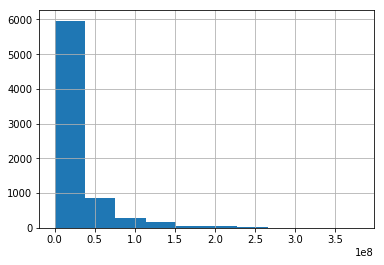

In [5]:
# De cette façon, on reconnait la cloche normale d'une variable linéaire.

###############################################################################
################################## Visualisation des variables explicatives et construction du dataset
###############################################################################
# L'idée est de visualiser toutes les variables une par une pour trouver une façon de les ajouter ou non au dataset.

################################## Budget
print(x_x['budget'].hist())
print(x_x['budget'].describe())

AxesSubplot(0.125,0.125;0.775x0.755)
count    7398.000000
mean       11.820750
std         7.465054
min         0.000000
25%         0.000000
50%        15.830414
75%        17.147715
max        19.755682
Name: budget_log, dtype: float64


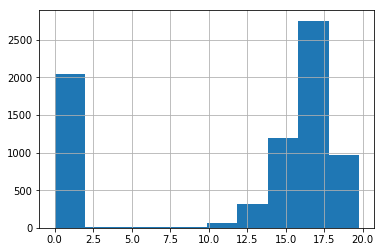

In [6]:
# Encore une fois, on voit que la variable n'est pas linéaire. Comme on a transformé la variable revenue pour
# la rendre linéaire, il est logique de faire la même chose.
# Par contre, le log n'existe pas en x = 0 et on peut voir que 25% de notre data de budget est à 0.
# Ça explique le +1
x_x["budget_log"] = np.log(x_x["budget"]+1)
print(x_x["budget_log"].hist())
print(x_x["budget_log"].describe())

In [7]:
# On le voit encore mieux ici.
# Clairement, il faudra faire quelque chose. Un film avec 0 de budget, ça existe pas.
# On a plusieurs options.

# Option 1 : Enlever les lignes du dataset où le budget est à 0
# Option 2 : Essayer, en utilisant les autres données, de prédire le budget lorsqu'il est à 0.
# Option 3 : Remplacer 0 par NULL
# Option 4 : Rien faire

# Certains modèles plus modernes et complexes ont des façons de traiter les valeurs nulles, mais pas les modèles classiques.
# Pour l'option 1, on ne peut pas vraiment l'utiliser, puisque dans le dataset de test, il y a des nulls aussi alors
# on n'est pas plus avancé.

# Le premier modèle sera une regression lineaire qui ne gère pas les nulls. Je vais donc utiliser l'option 4 pour voir
# la performance du modèle et ensuite utiliser l'option 2 pour voir s'il y a un gain.

################################## Belongs to collection
# Champ qui permet de savoir si le film fait parti d'une série, comme Seingeurs des Anneaux
print(x_x['belongs_to_collection'][0])

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]


In [8]:
# Le champ est stocké étrangement, alors il faut le cleaner un peu
# Avec ma fonction extraire_freq, je vais chercher pour chaque collection quel est le nombre d'occurence
# avec une triage descendant
freq = extraire_freq(x_x,'belongs_to_collection')
print(freq[0:10])

                                       freq  count
303                   James Bond Collection     26
228              Friday the 13th Collection     12
419                      Pokémon Collection      9
636  The Pink Panther (Original) Collection      8
260                 Harry Potter Collection      8
575     The Fast and the Furious Collection      8
19     A Nightmare on Elm Street Collection      8
254                    Halloween Collection      8
505                    Star Wars Collection      8
462                          Saw Collection      7


In [9]:
# Sur 7398 lignes, 7 occurences, ce n'est pas beaucoup. 
# Pour cette raison, je vais garder seulement les collections dans laquelle il y a eu au moins 8 films
# Donc les 9 premiers dans la liste

# Boucle pour me créer un DataFrame contenant dans chaque colonne une des 9 collections.
df_collection = pd.DataFrame()
for i in range(9):
    temp = list(freq["freq"][i:i+1])[0]
    df_collection["belongs_to_collection " + temp] = [1 if temp in j else 0 for j in x_x['belongs_to_collection']]

corr_mat = features_corr(df_collection.loc[idx_train,:],y_train_log)

# Ensuite, pour chaque collection, je regarde la corrélation avec la variable explicative.
print(corr_mat)

                                            col_name      coef  coef_abs
0        belongs_to_collection James Bond Collection  0.078764  0.078764
5  belongs_to_collection The Fast and the Furious...  0.044723  0.044723
4      belongs_to_collection Harry Potter Collection  0.039224  0.039224
8         belongs_to_collection Star Wars Collection  0.037566  0.037566
2           belongs_to_collection Pokémon Collection  0.025134  0.025134
1   belongs_to_collection Friday the 13th Collection  0.020699  0.020699
7         belongs_to_collection Halloween Collection  0.008681  0.008681
3  belongs_to_collection The Pink Panther (Origin...  0.005020  0.005020
6  belongs_to_collection A Nightmare on Elm Stree...       NaN       NaN


C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [10]:
# Disons que ça chute vite 
# Après Friday, on peut pas vraiment dire qu'il y a une corrélation. (<2%)
# Pour cette raison, dans mon dataset final, je ne vais ajouter que les 5 premières collections
# Avec mon architecture, je pouvoir simplement changer ce 5 pour un 9 si finalement je veux plus de collections.

collection_a_ajouter = corr_mat["col_name"][0:5]

# J'ai pris chaque collection individuellement pour la transformer en colonne, mais on pourrait aussi vouloir
# ajouter un indicateur de si le film fait partie d'une collection ou pas. Allons voir si ça paye.
df_belongs = pd.DataFrame([1 if i == "no belongs_to_collection" or pd.isnull(i) else 0 for i in x_x["belongs_to_collection"]], columns = ['belongs'])
print(np.corrcoef(y_train_log,df_belongs['belongs'][idx_train])[0][1])

-0.2559221145651392


In [11]:
# Comme c'est très bon, on va garder la variable.


##### Popularity
# x_x["popularity"].hist() ## Clairement exponentiel, on va transformer.
x_x["popularity_log"] = np.log(x_x["popularity"]+1)
# x_x["popularity_log"].hist() ## Meilleur

##### Runtime
x_x["runtime"] = x_x["runtime"].fillna(0)
# x_x["runtime"].hist() ## lineaire


##### Genres
df_genres = extraire_info(x_x,'genres')
corr_mat = features_corr(df_genres.loc[idx_train,:],y_train_log) 
genres_a_ajouter = corr_mat["col_name"][0:10]

##### Spoken langages : pas bon
# df_lang = extraire_info(x_x,'spoken_languages')
# corr_mat = features_corr(df_lang.iloc[:,1:56],y_train_log)
# lang_a_ajouter = corr_mat["col_name"][0:5]
# x_x_df = x_x_df.join(df_lang.iloc[:,lang_a_ajouter.index])


##### Orig lang
df_orig_lang = x_x.original_language.str.get_dummies()
corr_mat = features_corr(df_orig_lang.loc[idx_train,:],y_train_log)
orig_lang_a_ajouter = corr_mat["col_name"][0:2]


##### Prod countires
df_prod_count = extraire_info(x_x,'production_countries')
corr_mat = features_corr(df_prod_count.loc[idx_train,:],y_train_log)
prod_count_a_ajouter = corr_mat["col_name"][0:10]


##### Release date
df_date = pd.to_datetime(x_x['release_date'])
df_dow = pd.DataFrame([i.weekday() for i in df_date], columns = ['weekday'])
df_dow = df_dow.weekday.astype(str).str.get_dummies()
df_dow = df_dow.iloc[:,0:6]
df_dow.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_date = df_date.fillna(datetime.datetime(2000, 1, 1))
corr_mat = features_corr(df_prod_count.loc[idx_train,:],y_train_log)


### Production companies
freq = extraire_freq(x_x,'production_companies')
df_prod_comp = pd.DataFrame()
for i in range(1000):
    temp = list(freq["freq"][i:i+1])[0]
    df_prod_comp["prod comp " + temp] = [1 if temp in j else 0 for j in x_x['production_companies']]

corr_mat = features_corr(df_prod_comp.loc[idx_train,:],y_train_log)

prod_comp_a_ajouter = corr_mat["col_name"][0:10]


### crew
freq = extraire_freq(x_x,'crew')
df_crew = pd.DataFrame()
for i in range(250):
    temp = list(freq["freq"][i:i+1])[0]
    df_crew["crew " + temp] = [1 if temp in j else 0 for j in x_x['crew']]

corr_mat = features_corr(df_crew.loc[idx_train,:],y_train_log)

crew_a_ajouter = corr_mat["col_name"][0:10]
nb_crew = extraire_nb(x_x,'crew')


### cast
freq = extraire_freq(x_x,'cast')
df_cast = pd.DataFrame()
for i in range(500):
    temp = list(freq["freq"][i:i+1])[0]
    df_cast["cast " + temp] = [1 if temp in j else 0 for j in x_x['cast']]

corr_mat = features_corr(df_cast.loc[idx_train,:],y_train_log)

cast_a_ajouter = corr_mat["col_name"][0:10]
nb_cast = extraire_nb(x_x,'cast')


### keywords
freq = extraire_freq(x_x,'Keywords')
df_keywords = pd.DataFrame()
for i in range(500):
    temp = list(freq["freq"][i:i+1])[0]
    df_keywords["keywords " + temp] = [1 if temp in j else 0 for j in x_x['Keywords']]

corr_mat = features_corr(df_keywords.loc[idx_train,:],y_train_log)

keywords_a_ajouter = corr_mat["col_name"][0:10]

##### Matrice finale
x_x_df = x_x[["budget_log","popularity_log","runtime"]]
x_x_df = x_x_df.join(df_genres.iloc[:,genres_a_ajouter.index])
x_x_df = x_x_df.join(df_orig_lang.iloc[:,orig_lang_a_ajouter.index])
x_x_df = x_x_df.join(df_prod_count.iloc[:,prod_count_a_ajouter.index])
x_x_df = x_x_df.join(df_date.dt.year)
x_x_df = x_x_df.join(df_dow)
x_x_df = x_x_df.join(df_belongs)
x_x_df = x_x_df.join(pd.DataFrame([1 if pd.isnull(i) else 0 for i in x_x["homepage"]],columns=['has_web']))
x_x_df = x_x_df.rename(columns={'release_date': 'release_year'})
x_x_df = x_x_df.join(df_prod_comp.iloc[:,prod_comp_a_ajouter.index])
x_x_df = x_x_df.join(df_crew.iloc[:,crew_a_ajouter.index])
x_x_df = x_x_df.join(df_collection.iloc[:,collection_a_ajouter.index])
x_x_df = x_x_df.join(df_cast.iloc[:,cast_a_ajouter.index])
x_x_df = x_x_df.join(df_keywords.iloc[:,keywords_a_ajouter.index])
x_x_df = x_x_df.join(nb_cast)
x_x_df = x_x_df.join(nb_crew)

# Fonction géniale qui permet de diviser le dataset, en enlevant les budgets null
x_train_spl, x_valid_spl, y_train_spl, y_valid_spl = train_test_split(
        x_x_df.loc[idx_train,:], y_train_log[idx_train], test_size=0.33, random_state=0)

C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\sagau\Anaconda3\lib\site-packages\numpy\lib\function_ba

In [12]:
###############################################################################
################################## Moment attendu, construction de modèle !
###############################################################################
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x_train_spl, y_train_spl)
    
y_train_pred = model.predict(x_train_spl)  
y_valid_pred = model.predict(x_valid_spl)

print(rmsle(list(np.exp(y_train_spl)), list(np.exp(y_train_pred)))
     ,rmsle(list(np.exp(y_valid_spl)), list(np.exp(y_valid_pred))))

2.182433424771886 2.155702072079922


In [ ]:
$ ipython locate
